# Covid prediction on X-ray images

## Data Preparation

## First let's split data into train/validation folders with images in 80/20 ratio

In [1]:
import os
import numpy as np
import shutil

# # Creating Train / Val / Test folders (One time use)
root_dir = 'X-ray'
positive_class = 'COVID'
negative_class = 'Non-COVID'
try:
    os.makedirs(root_dir +'/train/' + positive_class)
    os.makedirs(root_dir +'/train/' + negative_class)
    os.makedirs(root_dir +'/val/' + positive_class)
    os.makedirs(root_dir +'/val/' + negative_class)
    
    # Creating partitions of the data after shuffling
    for class_covid in [positive_class,negative_class]:
        currentCls = class_covid
        src = root_dir + "/" + currentCls # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)*0.8)])


        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

        print('Total images: ',currentCls, len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir+"/train/"+currentCls)

        for name in val_FileNames:
            shutil.copy(name, root_dir+"/val/"+currentCls)
except:
    pass

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt



In [3]:
def set_seed(seed_value=1234):
    """Set seed for reproducibility.
    """
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [4]:
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_set = datasets.ImageFolder(root_dir+"/train", transform = transformations)
val_set = datasets.ImageFolder(root_dir+"/val", transform = transformations)

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

### Setting up the model

In [7]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

In [80]:
#mod = models.googlenet(pretrained=True)

mod = models.densenet201(pretrained=True)

In [81]:
num_labels = 2

# Dropout applied after pretrained model as not all features are directly useful

model = nn.Sequential(mod,
                      nn.Dropout(p=0.2),
                      nn.Linear(1000, 128),
                      nn.ReLU(),
                      nn.Linear(128, num_labels),
                      nn.LogSoftmax(dim=1)
                     )

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, a

### Phase 1: Feature extraction 

I.e. Training the additional layers we attach for our task

In [83]:
# Freeze pretrained layers

for param in mod.parameters():
    param.requires_grad = False

In [84]:
# Set the error function using torch.nn as nn library
criterion = nn.NLLLoss()
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.parameters(),weight_decay=0.0001,lr=0.0005)
# Set the seeds for reproducibility
set_seed(1234)

In [85]:
epochs = 10

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
#            print(counter, "/", len(train_loader))
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1

#                print(counter, "/", len(val_loader))
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    # Print out the information
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

Accuracy:  0.9267857144276301
Epoch: 1 	Training Loss: 0.264104 	Validation Loss: 0.199155
Accuracy:  0.9262896825869879
Epoch: 2 	Training Loss: 0.191839 	Validation Loss: 0.194818
Accuracy:  0.935912698507309
Epoch: 3 	Training Loss: 0.165487 	Validation Loss: 0.171448
Accuracy:  0.9375
Epoch: 4 	Training Loss: 0.150799 	Validation Loss: 0.169154
Accuracy:  0.9395833333333333
Epoch: 5 	Training Loss: 0.143274 	Validation Loss: 0.163207
Accuracy:  0.9413690477609634
Epoch: 6 	Training Loss: 0.126865 	Validation Loss: 0.173328
Accuracy:  0.9398313492536545
Epoch: 7 	Training Loss: 0.123446 	Validation Loss: 0.169848
Accuracy:  0.9341021825869879
Epoch: 8 	Training Loss: 0.113705 	Validation Loss: 0.186284
Accuracy:  0.9395833333333333
Epoch: 9 	Training Loss: 0.104242 	Validation Loss: 0.178570
Accuracy:  0.9338541666666667
Epoch: 10 	Training Loss: 0.102379 	Validation Loss: 0.170697


### Phase 2: Fine-tuning the full model

In [86]:
## UNFREEZING THE PRETRAINED LAYERS

for param in mod.parameters():
    param.requires_grad = True
    
criterion = nn.NLLLoss()

# Lowered weight decay & learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(),weight_decay=0.00003,lr=3e-5)

In [87]:
epochs = 7
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
 
        #print(counter, "/", len(train_loader))
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1

            #print(counter, "/", len(val_loader))
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    # Print out the information
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

Accuracy:  0.9481646825869878
Epoch: 1 	Training Loss: 0.106845 	Validation Loss: 0.141174
Accuracy:  0.9575396825869879
Epoch: 2 	Training Loss: 0.056518 	Validation Loss: 0.136105
Accuracy:  0.9598958333333333
Epoch: 3 	Training Loss: 0.035660 	Validation Loss: 0.134201
Accuracy:  0.9606646825869878
Epoch: 4 	Training Loss: 0.029495 	Validation Loss: 0.136117
Accuracy:  0.9578125
Epoch: 5 	Training Loss: 0.026860 	Validation Loss: 0.171780
Accuracy:  0.9591021825869878
Epoch: 6 	Training Loss: 0.023212 	Validation Loss: 0.160641
Accuracy:  0.9572916666666667
Epoch: 7 	Training Loss: 0.021526 	Validation Loss: 0.185011


### Prediction Explanability


Load our test image and see how it looks.

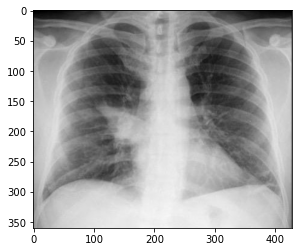

In [236]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./000001-9-a.jpg') #Load input image
plt.imshow(img)

In [237]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [238]:
from torch.autograd import Variable
import torch.nn.functional as F

In [239]:
from lime import lime_image

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [240]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [241]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Import lime and create explanation for this prediciton.

In [242]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function


Let's use mask on image and see the areas that are encouraging the top prediction.

In [243]:
from skimage.segmentation import mark_boundaries

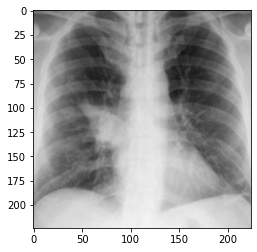

In [244]:
#Assign image to POSITIVE CLASS

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)


Let's turn on areas that contributes against the top prediction. <b> We can also see the 'pros and cons' (pros in green, cons in red)

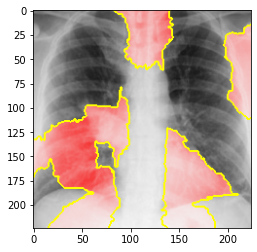

In [245]:

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)